In [109]:
import os
import numpy as np
import tensorflow.keras.preprocessing.image as img_preproc
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
from models import get_model

input_dir = "images/train/"
target_dir = "annotations/train/"
img_size = (160, 160)
num_classes = 2
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    
assert len(input_img_paths)>0,"input_dir is empty"
assert len(input_img_paths)>0,"target_dir is empty"

Number of samples: 900
images/train/ISIC_0000000.jpg | annotations/train/ISIC_0000000_Segmentation.png
images/train/ISIC_0000001.jpg | annotations/train/ISIC_0000001_Segmentation.png
images/train/ISIC_0000002.jpg | annotations/train/ISIC_0000002_Segmentation.png
images/train/ISIC_0000004.jpg | annotations/train/ISIC_0000004_Segmentation.png
images/train/ISIC_0000006.jpg | annotations/train/ISIC_0000006_Segmentation.png
images/train/ISIC_0000007.jpg | annotations/train/ISIC_0000007_Segmentation.png
images/train/ISIC_0000008.jpg | annotations/train/ISIC_0000008_Segmentation.png
images/train/ISIC_0000009.jpg | annotations/train/ISIC_0000009_Segmentation.png
images/train/ISIC_0000010.jpg | annotations/train/ISIC_0000010_Segmentation.png
images/train/ISIC_0000011.jpg | annotations/train/ISIC_0000011_Segmentation.png


In [5]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-11-02 21:02:38.328544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 21:02:38.352421: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1896300000 Hz
2022-11-02 21:02:38.353428: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x527af50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-02 21:02:38.353448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [122]:
import random
from dataset import ISICChallenge

# Split our img paths into a training and a validation set
val_samples = 150
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = ISICChallenge(
    batch_size, img_size, train_input_img_paths, train_target_img_paths, shuffle=False, augment=False
)
val_gen = ISICChallenge(
    batch_size, img_size, val_input_img_paths, val_target_img_paths, shuffle=False, augment=False
)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

metrics = ['accuracy']

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=metrics)

In [8]:
callbacks = [
    ModelCheckpoint("isic-challenge_segmentation_baseline.h5", save_best_only=True),
    EarlyStopping(min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
]

# Train the model for 50 epochs, in reality it will stop earlier because of the EarlyStopping
epochs = 50
history = model.fit(train_gen, 
                    epochs=epochs, 
                    validation_data=val_gen, 
                    callbacks=callbacks)

Epoch 1/50
46/46 [==============================] - 48s 1s/step - loss: 1.2925 - accuracy: 0.7389 - val_loss: 1.1261 - val_accuracy: 0.3228
Epoch 2/50
46/46 [==============================] - 48s 1s/step - loss: 0.3548 - accuracy: 0.7475 - val_loss: 0.6869 - val_accuracy: 0.9621
Epoch 3/50
46/46 [==============================] - 48s 1s/step - loss: 0.2507 - accuracy: 0.7454 - val_loss: 0.8675 - val_accuracy: 0.9461
Epoch 4/50
46/46 [==============================] - 48s 1s/step - loss: 0.2248 - accuracy: 0.7494 - val_loss: 1.0339 - val_accuracy: 0.9815
Epoch 5/50
46/46 [==============================] - 48s 1s/step - loss: 0.1905 - accuracy: 0.7436 - val_loss: 0.9605 - val_accuracy: 0.9939
Epoch 6/50
46/46 [==============================] - 51s 1s/step - loss: 0.1780 - accuracy: 0.7422 - val_loss: 1.3317 - val_accuracy: 0.9818
Epoch 7/50
46/46 [==============================] - 55s 1s/step - loss: 0.1598 - accuracy: 0.7411 - val_loss: 0.9580 - val_accuracy: 0.9898
Epoch 8/50
46/46 [==

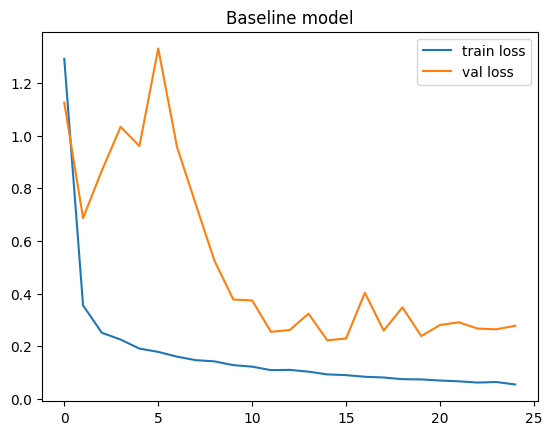

In [136]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc="upper right")
plt.title("Baseline model")
plt.show()

# Model evaluation - validation set

In [ ]:
from segmentation_metrics import calculate_metrics

val_gen = ISICChallenge(1, 
                        img_size, 
                        val_input_img_paths, 
                        val_target_img_paths, 
                        shuffle=False, 
                        augment=False)

val_preds = model.predict(val_gen)

In [124]:
y = np.zeros((len(val_input_img_paths),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(val_target_img_paths):
    mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [125]:
y = np.squeeze(y)
pr_masks = np.argmax(val_preds, axis=-1)
y.shape, pr_masks.shape

((150, 160, 160), (150, 160, 160))

In [126]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

Specificity: 0.9732222557067871
Sensitivity(Recall): 0.8026036620140076
Jaccard score: 0.749925061537702
Dice coefficient: 0.857
Accuracy: 0.9261325597763062


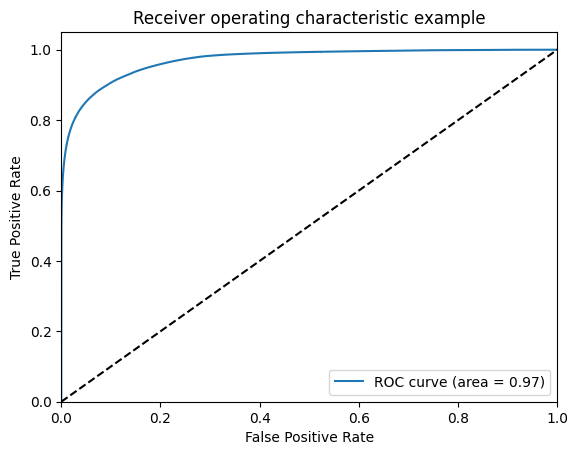

In [127]:
calculate_metrics(y, val_preds)

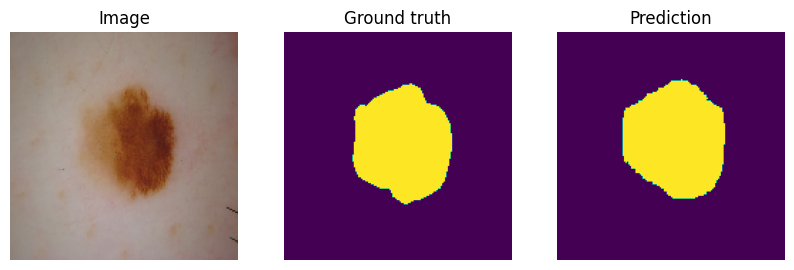

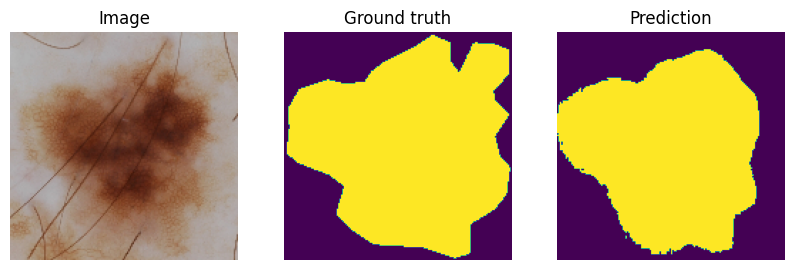

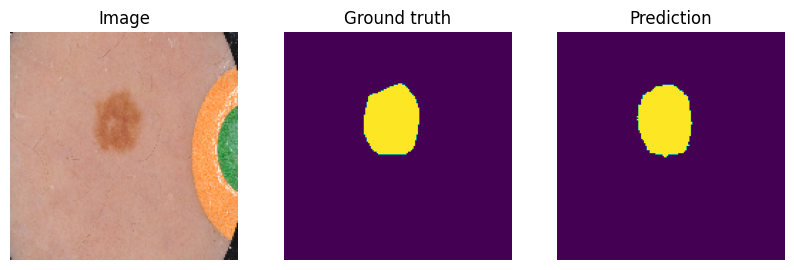

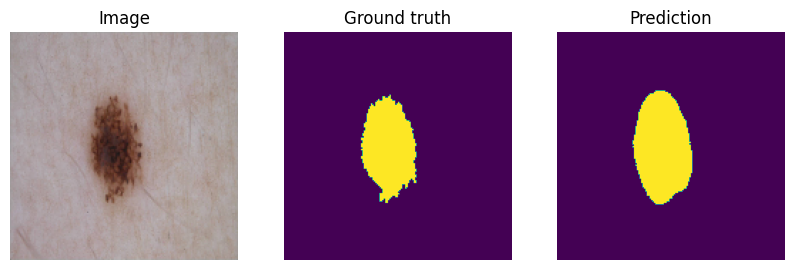

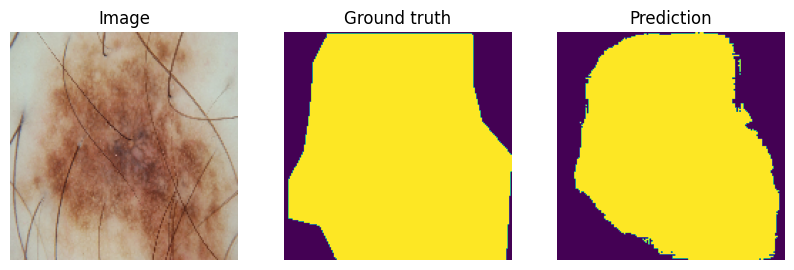

In [137]:
max_img = 5
pr_masks = np.argmax(val_preds, axis=-1)
    
for img_path, mask_path, pr_mask in zip(val_input_img_paths[:max_img], 
                                        val_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Model evaluation - Test set

In [105]:
input_dir = "images/test/"
target_dir = "annotations/test/"

test_input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(test_input_img_paths))

Number of samples: 379


In [91]:
test_gen = ISICChallenge(
    1, img_size, test_input_img_paths, test_target_img_paths, shuffle=False, augment=False
)

In [92]:
test_preds = model.predict(test_gen)

### load all masks as used in training to calculate metrics

In [93]:
y = np.zeros((len(test_input_img_paths),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(test_target_img_paths):
    mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [94]:
y = np.squeeze(y)
pr_masks = np.argmax(test_preds, axis=-1)
y.shape, pr_masks.shape

((379, 160, 160), (379, 160, 160))

In [95]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

Specificity: 0.9651851058006287
Sensitivity(Recall): 0.8637375831604004
Jaccard score: 0.7933730031589433
Dice coefficient: 0.885
Accuracy: 0.9365880489349365


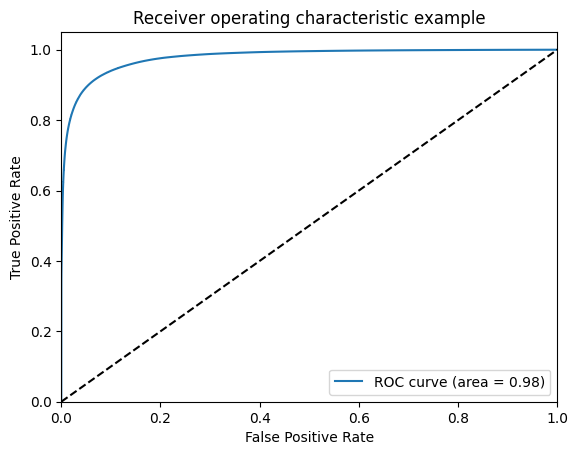

In [106]:
calculate_metrics(y, test_preds)

## Visualization

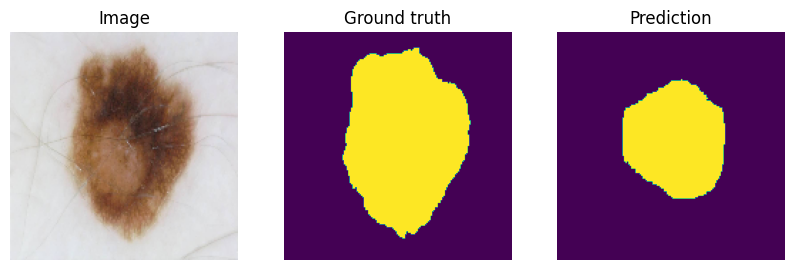

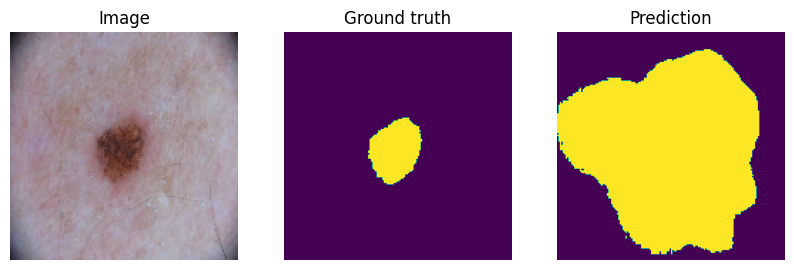

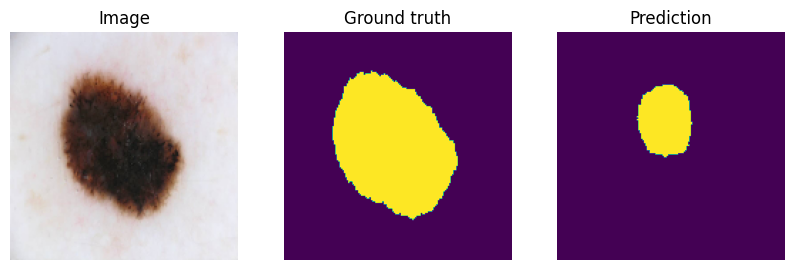

In [138]:
max_img = 3
    
for img_path, mask_path, pr_mask in zip(test_input_img_paths[:max_img], 
                                        test_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()